In [44]:
#Add repo path to the system path
from pathlib import Path
import os, sys
repo_path= Path.cwd().resolve()
while '.gitignore' not in os.listdir(repo_path): # while not in the root of the repo
    repo_path = repo_path.parent #go up one level
sys.path.insert(0,str(repo_path)) if str(repo_path) not in sys.path else None

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"
device = 0

In [67]:
from importlib import import_module
from sklearn.model_selection import KFold
from monai.transforms import (
    Compose,
    ScaleIntensityd,
    EnsureTyped,
    EnsureChannelFirstd,
    Resized,
)
import numpy as np
import torch
import SimpleITK as sitk
from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot as plt

In [4]:
# special imports
sys.path.append(str(repo_path / 'SAMed'))
from SAMed.segment_anything import sam_model_registry

In [16]:
class ABUS_dataset(Dataset):
    
    def __init__(self, list_dir, transform=None):
        self.transform = transform  # using transform in torch!
        images = [sitk.GetArrayFromImage(sitk.ReadImage(str(i))) for i in list_dir[0]]
        labels = [sitk.GetArrayFromImage(sitk.ReadImage(str(i))) for i in list_dir[1]]

        self.sample_list = np.array(list(zip(images,labels)))
        
        self.resize=Compose([Resized(keys=["label"], spatial_size=(64, 64),mode=['nearest'])])

    def __len__(self):
        return len(self.sample_list)

    def __getitem__(self, idx):
        
        if self.transform:
            sample=self.transform({"image": self.sample_list[idx][0], "label": self.sample_list[idx][1]})
        
        sample['low_res_label']=self.resize({"label":sample['label']})['label'][0]
        sample['label']=sample['label'][0]
        return sample

# Inference of SAMed

## Setup

Model

In [46]:
checkpoint_dir = repo_path / 'checkpoints'

# get SAM model
sam, _ = sam_model_registry['vit_b'](image_size=256,
                                    num_classes=2,
                                    checkpoint=str(checkpoint_dir / 'sam_vit_b_01ec64.pth'),
                                    pixel_mean=[0, 0, 0],
                                    pixel_std=[1, 1, 1])
# load lora model
pkg = import_module('sam_lora_image_encoder')
model = pkg.LoRA_Sam(sam, 4)
# load weighs
load_path = repo_path / 'experiments/SAMed_ABUS/weights/fold0/epoch_95.pth'
model.load_lora_parameters(str(load_path))
model.eval()
model.to(device);

Data

In [89]:
# create fold
kf = KFold(n_splits=5,shuffle=True,random_state=0)
for fold_n, (train_ids, val_ids) in enumerate(kf.split(range(100))):
    break
print(f'The number of patients in the validation set is {len(val_ids)}')
print(f'The patient ids in the validation set are {val_ids}')
# transform
val_transform = Compose(
        [
            EnsureChannelFirstd(keys=['label'], channel_dim='no_channel'),

            ScaleIntensityd(keys=["image"]),

            Resized(keys=["image", "label"], spatial_size=(256, 256),mode=['area','nearest']),
            EnsureTyped(keys=["image"])
        ])

The number of patients in the validation set is 20
The patient ids in the validation set are [ 2  7  8 13 16 22 24 26 30 33 53 54 55 73 75 78 86 92 93 95]


In [96]:
# HP
batch_size = 32
multimask_output = True

# get data
root_path = repo_path / 'data/challange_2023/with_lesion'
path_images = (root_path / "image_mha")
path_labels = (root_path / "label_mha")
# get all files in the folder in a list, only mha files
image_files = sorted([file for file in os.listdir(path_images) if file.endswith('.mha')])
# now, we will check if the path has at least one of the ids in the train_ids list
val_files = [file for file in image_files if any(f'id_{id}_' in file for id in val_ids)]
# create final paths
image_files = np.array([path_images / i for i in val_files])
label_files = np.array([path_labels / i for i in val_files])
list_val = [image_files, label_files] # this is what we will pass to the dataset <-

# define dataset and dataloader
db_val = ABUS_dataset(transform=val_transform,list_dir=list_val)   
valloader = DataLoader(db_val, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True)

/tmp/ipykernel_2885206/37536157.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.sample_list = np.array(list(zip(images,labels)))


## Evaluate

In [97]:
# get example from valloader
sample_batch = next(iter(valloader))

In [98]:
image_batch, label_batch = sample_batch["image"].to(device), sample_batch["label"].to(device)
low_res_label_batch = sample_batch['low_res_label'].to(device)

# forward and losses computing
outputs = model(image_batch, multimask_output, 256)
output_masks = outputs['masks'].detach().cpu()
output_masks = torch.argmax(torch.softmax(output_masks, dim=1), dim=1, keepdim=True)

Text(0.5, 1.0, 'Predicted mask')

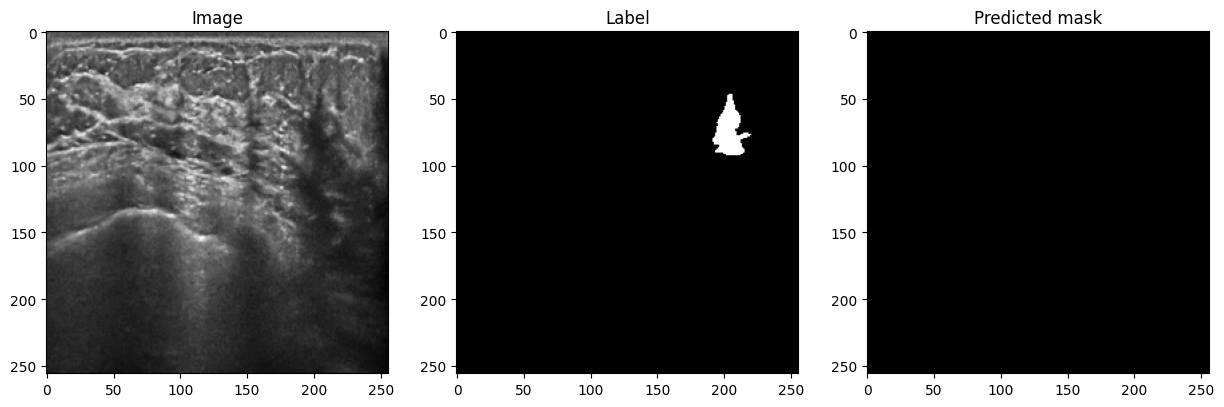

In [109]:
batch_num = -10
# show image, label and predicted mask
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(image_batch[batch_num, 0, :, :].cpu().numpy(), cmap='gray')
axs[0].set_title('Image')
axs[1].imshow(label_batch[batch_num, :, :].cpu().numpy(), cmap='gray')
axs[1].set_title('Label')
axs[2].imshow(output_masks[batch_num, 0, :, :].numpy(), cmap='gray')
axs[2].set_title('Predicted mask')